# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plots
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [4]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

###### Para Classificação Multiclasse

In [6]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

# Inicialização de Pesos

In [7]:
def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # normal com media=0 e stddev=sqrt(3.0 / (out + inp)). Ver notas de np.random.randn.
    std_dev = np.sqrt(3.0 / (rows + cols))
    return std_dev*np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # uniforme de [-limit, limit], onde limit = np.sqrt(6.0 / (out + inp))
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows, cols) - limit

# Regularização

###### Dos Pesos

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return [np.where(w > 0, 1, w) for w in weights]
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return np.sum([0.5*np.sum(w**2) for w in weights])

# Implementação 

In [9]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self._activ_inp, self._activ_out = None, None
        self.dweights, self.dbiases = None, None       

class NeuralNetwork():
    def __init__(self, cost_func, learning_rate=1e-3, reg_func=l2_regularization, reg_strength=0.0):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        
    def fit(self, x, y, epochs=100, verbose=10):
        for epoch in range(epochs+1):
            y_pred = self.__feedforward(x)
            self.__backprop(y, y_pred)
            
            if epoch % verbose == 0:
                data_loss = self.cost_func(y, y_pred)/x.shape[0]
                reg_loss = self.reg_strength*self.reg_func([layer.weights for layer in self.layers])
                print("epoch: {0:=4}/{1} data_loss:{2:.8f} reg_loss:{3:.8f} cost:{4:.8f}".format(epoch, epochs, data_loss, reg_loss, data_loss + reg_loss))
        
    def predict(self, x):
        return self.__feedforward(x)
    
    def __feedforward(self, x):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:]+[Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True)*last_delta
            last_delta = np.dot(dactivation, layer.weights)
            layer.dweights = np.dot(dactivation.T, layer.input)
            layer.dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)
        
        dregularization = self.reg_func([layer.weights for layer in self.layers], derivative=True)
        for layer, dreg in zip(reversed(self.layers), reversed(dregularization)):
            layer.dweights = layer.dweights + self.reg_strength*dreg
            layer.weights = layer.weights - self.learning_rate*layer.dweights
            layer.biases = layer.biases - self.learning_rate*layer.dbiases

# Testes da Implementação

## Exemplos do Notebook da Intuição

### Exemplo 1

In [10]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]])
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 data_loss:0.29837111 reg_loss:0.00000000 cost:0.29837111
[[ 0.14978072  0.19956143]
 [ 0.24975114  0.29950229]]
[[ 0.35891648  0.40866619]
 [ 0.51130127  0.56137012]]


### Exemplo 2

In [11]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 data_loss:1.16744561 reg_loss:0.00000000 cost:1.16744561
epoch:   30/300 data_loss:0.60797958 reg_loss:0.00000000 cost:0.60797958
epoch:   60/300 data_loss:0.36558760 reg_loss:0.00000000 cost:0.36558760
epoch:   90/300 data_loss:0.24943452 reg_loss:0.00000000 cost:0.24943452
epoch:  120/300 data_loss:0.18547915 reg_loss:0.00000000 cost:0.18547915
epoch:  150/300 data_loss:0.14614615 reg_loss:0.00000000 cost:0.14614615
epoch:  180/300 data_loss:0.11990516 reg_loss:0.00000000 cost:0.11990516
epoch:  210/300 data_loss:0.10131084 reg_loss:0.00000000 cost:0.10131084
epoch:  240/300 data_loss:0.08751844 reg_loss:0.00000000 cost:0.08751844
epoch:  270/300 data_loss:0.07691721 reg_loss:0.00000000 cost:0.07691721
epoch:  300/300 data_loss:0.06853445 reg_loss:0.00000000 cost:0.06853445
[[ 0.10083595  0.2016719   0.30585165]
 [ 0.30086971  0.20173942  0.70608796]
 [ 0.40145052  0.30290104  0.91015363]]
[[ 0.20544723  0.30673159  0.50749567]
 [ 0.30994562  0.5123005   0.71366784]
 

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

In [12]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [13]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 1.0


epoch:    0/1000 data_loss:56.03779994 reg_loss:0.00000000 cost:56.03779994
epoch:  100/1000 data_loss:0.31300217 reg_loss:0.00000000 cost:0.31300217
epoch:  200/1000 data_loss:0.26202765 reg_loss:0.00000000 cost:0.26202765
epoch:  300/1000 data_loss:0.26085668 reg_loss:0.00000000 cost:0.26085668
epoch:  400/1000 data_loss:0.26082978 reg_loss:0.00000000 cost:0.26082978
epoch:  500/1000 data_loss:0.26082916 reg_loss:0.00000000 cost:0.26082916
epoch:  600/1000 data_loss:0.26082915 reg_loss:0.00000000 cost:0.26082915
epoch:  700/1000 data_loss:0.26082914 reg_loss:0.00000000 cost:0.26082914
epoch:  800/1000 data_loss:0.26082914 reg_loss:0.00000000 cost:0.26082914
epoch:  900/1000 data_loss:0.26082914 reg_loss:0.00000000 cost:0.26082914
epoch: 1000/1000 data_loss:0.26082914 reg_loss:0.00000000 cost:0.26082914
[[ 33.60164745]]
[[ 74.99636286]]


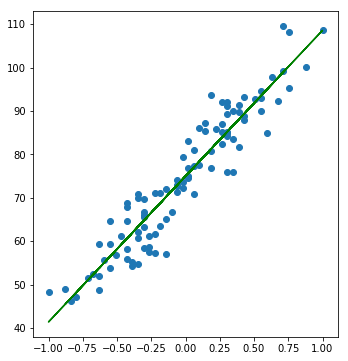

In [14]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [15]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [16]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [ 1.  1.  1.]


In [17]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 data_loss:1067.36353744 reg_loss:0.00000000 cost:1067.36353744
epoch:  200/2000 data_loss:0.27676051 reg_loss:0.00000000 cost:0.27676051
epoch:  400/2000 data_loss:0.23336459 reg_loss:0.00000000 cost:0.23336459
epoch:  600/2000 data_loss:0.22995777 reg_loss:0.00000000 cost:0.22995777
epoch:  800/2000 data_loss:0.22956884 reg_loss:0.00000000 cost:0.22956884
epoch: 1000/2000 data_loss:0.22951960 reg_loss:0.00000000 cost:0.22951960
epoch: 1200/2000 data_loss:0.22951324 reg_loss:0.00000000 cost:0.22951324
epoch: 1400/2000 data_loss:0.22951241 reg_loss:0.00000000 cost:0.22951241
epoch: 1600/2000 data_loss:0.22951230 reg_loss:0.00000000 cost:0.22951230
epoch: 1800/2000 data_loss:0.22951229 reg_loss:0.00000000 cost:0.22951229
epoch: 2000/2000 data_loss:0.22951229 reg_loss:0.00000000 cost:0.22951229
[[  8.72094483  14.10519201  26.26731945]]
[[ 150.65173202]]


### Regressão Quadrática

In [18]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [19]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 data_loss:21.17003761 reg_loss:0.00000000 cost:21.17003761
epoch: 1000/10000 data_loss:3.28651630 reg_loss:0.00000000 cost:3.28651630
epoch: 2000/10000 data_loss:0.75969506 reg_loss:0.00000000 cost:0.75969506
epoch: 3000/10000 data_loss:0.45173257 reg_loss:0.00000000 cost:0.45173257
epoch: 4000/10000 data_loss:0.36565796 reg_loss:0.00000000 cost:0.36565796
epoch: 5000/10000 data_loss:0.33322333 reg_loss:0.00000000 cost:0.33322333
epoch: 6000/10000 data_loss:0.31838750 reg_loss:0.00000000 cost:0.31838750
epoch: 7000/10000 data_loss:0.31034014 reg_loss:0.00000000 cost:0.31034014
epoch: 8000/10000 data_loss:0.30513148 reg_loss:0.00000000 cost:0.30513148
epoch: 9000/10000 data_loss:0.30063174 reg_loss:0.00000000 cost:0.30063174
epoch: 10000/10000 data_loss:0.29623351 reg_loss:0.00000000 cost:0.29623351


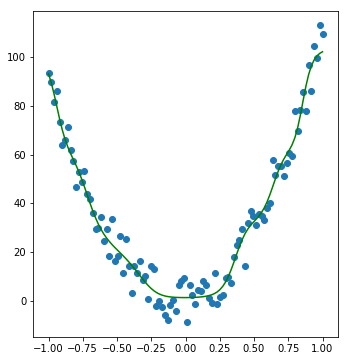

In [20]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [21]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [22]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 data_loss:1.02380321 reg_loss:0.00000000 cost:1.02380321
epoch: 1000/10000 data_loss:0.66827387 reg_loss:0.00000000 cost:0.66827387
epoch: 2000/10000 data_loss:0.32036669 reg_loss:0.00000000 cost:0.32036669
epoch: 3000/10000 data_loss:0.12325106 reg_loss:0.00000000 cost:0.12325106
epoch: 4000/10000 data_loss:0.06206615 reg_loss:0.00000000 cost:0.06206615
epoch: 5000/10000 data_loss:0.04846415 reg_loss:0.00000000 cost:0.04846415
epoch: 6000/10000 data_loss:0.03883464 reg_loss:0.00000000 cost:0.03883464
epoch: 7000/10000 data_loss:0.03524021 reg_loss:0.00000000 cost:0.03524021
epoch: 8000/10000 data_loss:0.03368518 reg_loss:0.00000000 cost:0.03368518
epoch: 9000/10000 data_loss:0.03276074 reg_loss:0.00000000 cost:0.03276074
epoch: 10000/10000 data_loss:0.03209688 reg_loss:0.00000000 cost:0.03209688


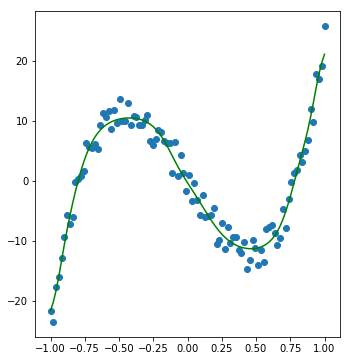

In [23]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [24]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [25]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 data_loss:0.00915487 reg_loss:0.00000000 cost:0.00915487
epoch: 1000/10000 data_loss:0.00028868 reg_loss:0.00000000 cost:0.00028868
epoch: 2000/10000 data_loss:0.00028666 reg_loss:0.00000000 cost:0.00028666
epoch: 3000/10000 data_loss:0.00028520 reg_loss:0.00000000 cost:0.00028520
epoch: 4000/10000 data_loss:0.00028400 reg_loss:0.00000000 cost:0.00028400
epoch: 5000/10000 data_loss:0.00028298 reg_loss:0.00000000 cost:0.00028298
epoch: 6000/10000 data_loss:0.00028210 reg_loss:0.00000000 cost:0.00028210
epoch: 7000/10000 data_loss:0.00028133 reg_loss:0.00000000 cost:0.00028133
epoch: 8000/10000 data_loss:0.00028065 reg_loss:0.00000000 cost:0.00028065
epoch: 9000/10000 data_loss:0.00028005 reg_loss:0.00000000 cost:0.00028005
epoch: 10000/10000 data_loss:0.00027951 reg_loss:0.00000000 cost:0.00027951


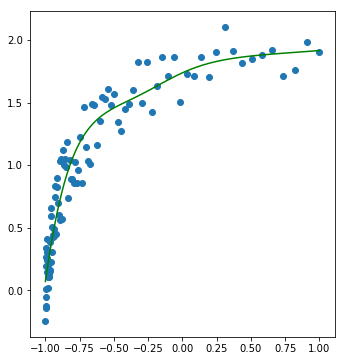

In [26]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-4)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [27]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [28]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 data_loss:12.77339513 reg_loss:0.00000000 cost:12.77339513
epoch: 1000/10000 data_loss:0.31886707 reg_loss:0.00000000 cost:0.31886707
epoch: 2000/10000 data_loss:0.29414956 reg_loss:0.00000000 cost:0.29414956
epoch: 3000/10000 data_loss:0.29258968 reg_loss:0.00000000 cost:0.29258968
epoch: 4000/10000 data_loss:0.29202474 reg_loss:0.00000000 cost:0.29202474
epoch: 5000/10000 data_loss:0.29163045 reg_loss:0.00000000 cost:0.29163045
epoch: 6000/10000 data_loss:0.29132394 reg_loss:0.00000000 cost:0.29132394
epoch: 7000/10000 data_loss:0.29107310 reg_loss:0.00000000 cost:0.29107310
epoch: 8000/10000 data_loss:0.29085378 reg_loss:0.00000000 cost:0.29085378
epoch: 9000/10000 data_loss:0.29066449 reg_loss:0.00000000 cost:0.29066449
epoch: 10000/10000 data_loss:0.29049635 reg_loss:0.00000000 cost:0.29049635


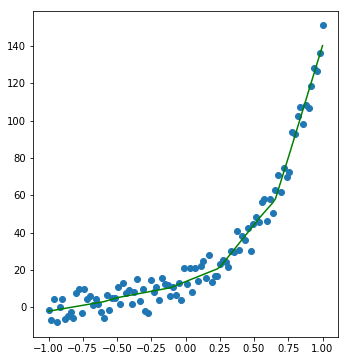

In [29]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [30]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 data_loss:0.33043048 reg_loss:0.06375272 cost:0.39418320
epoch: 1000/5000 data_loss:0.07160600 reg_loss:0.15234694 cost:0.22395294
epoch: 2000/5000 data_loss:0.07160599 reg_loss:0.15234696 cost:0.22395296
epoch: 3000/5000 data_loss:0.07160599 reg_loss:0.15234696 cost:0.22395296
epoch: 4000/5000 data_loss:0.07160599 reg_loss:0.15234696 cost:0.22395296
epoch: 5000/5000 data_loss:0.07160599 reg_loss:0.15234696 cost:0.22395296
[[ 1.52346962  1.52346962]] [[-2.63959782]]
Predições:
[[ 0.06663304]
 [ 0.24673017]
 [ 0.24673017]
 [ 0.60045023]]
Acurácia: 100.00%


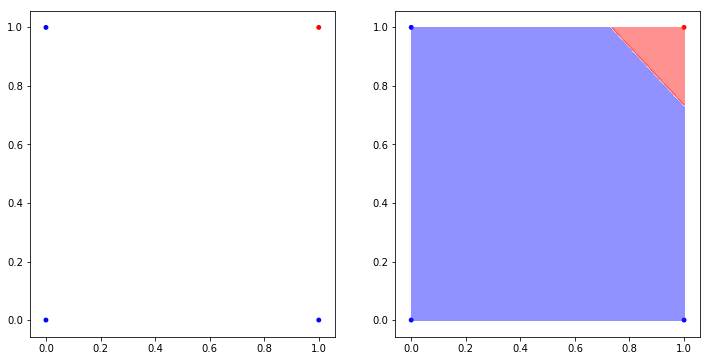

In [31]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0, reg_func=l1_regularization, reg_strength=0.05)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

print(nn.layers[0].weights, nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

In [32]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 data_loss:0.18351301 reg_loss:0.00000000 cost:0.18351301
epoch: 1000/5000 data_loss:0.01380585 reg_loss:0.00000000 cost:0.01380585
epoch: 2000/5000 data_loss:0.00767930 reg_loss:0.00000000 cost:0.00767930
epoch: 3000/5000 data_loss:0.00584289 reg_loss:0.00000000 cost:0.00584289
epoch: 4000/5000 data_loss:0.00488502 reg_loss:0.00000000 cost:0.00488502
epoch: 5000/5000 data_loss:0.00427614 reg_loss:0.00000000 cost:0.00427614
Predições:
[[ 0.01703489]
 [ 0.98378385]
 [ 0.98062659]
 [ 0.01519918]]
Acurácia: 100.00%


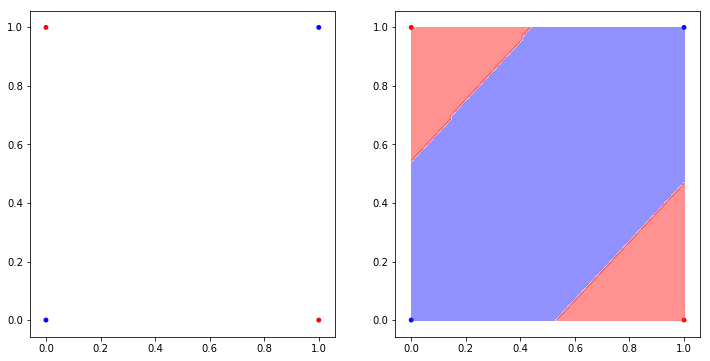

In [33]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

In [34]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 data_loss:0.04783919 reg_loss:0.00000000 cost:0.04783919
epoch: 1000/5000 data_loss:0.04595663 reg_loss:0.00000000 cost:0.04595663
epoch: 2000/5000 data_loss:0.04308849 reg_loss:0.00000000 cost:0.04308849
epoch: 3000/5000 data_loss:0.03683409 reg_loss:0.00000000 cost:0.03683409
epoch: 4000/5000 data_loss:0.00046471 reg_loss:0.00000000 cost:0.00046471
epoch: 5000/5000 data_loss:0.00026960 reg_loss:0.00000000 cost:0.00026960
Acurácia: 100.00%


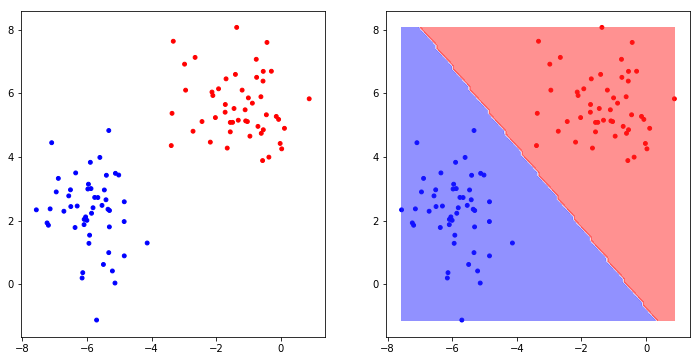

In [36]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 4 Clusters

In [37]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/5000 data_loss:0.00353010 reg_loss:0.00000000 cost:0.00353010
epoch: 1000/5000 data_loss:0.00000831 reg_loss:0.00000000 cost:0.00000831
epoch: 2000/5000 data_loss:0.00000473 reg_loss:0.00000000 cost:0.00000473
epoch: 3000/5000 data_loss:0.00000343 reg_loss:0.00000000 cost:0.00000343
epoch: 4000/5000 data_loss:0.00000273 reg_loss:0.00000000 cost:0.00000273
epoch: 5000/5000 data_loss:0.00000230 reg_loss:0.00000000 cost:0.00000230
Acurácia: 100.00%


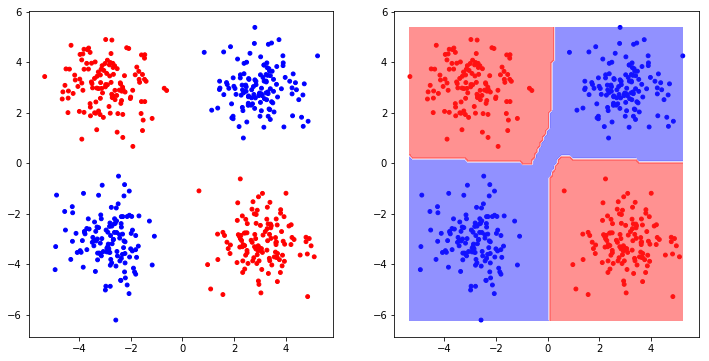

In [39]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

In [40]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/10000 data_loss:0.00399082 reg_loss:0.00000000 cost:0.00399082
epoch: 1000/10000 data_loss:0.00093825 reg_loss:0.00000000 cost:0.00093825
epoch: 2000/10000 data_loss:0.00006610 reg_loss:0.00000000 cost:0.00006610
epoch: 3000/10000 data_loss:0.00003978 reg_loss:0.00000000 cost:0.00003978
epoch: 4000/10000 data_loss:0.00003097 reg_loss:0.00000000 cost:0.00003097
epoch: 5000/10000 data_loss:0.00002627 reg_loss:0.00000000 cost:0.00002627
epoch: 6000/10000 data_loss:0.00002329 reg_loss:0.00000000 cost:0.00002329
epoch: 7000/10000 data_loss:0.00002120 reg_loss:0.00000000 cost:0.00002120
epoch: 8000/10000 data_loss:0.00001965 reg_loss:0.00000000 cost:0.00001965
epoch: 9000/10000 data_loss:0.00001844 reg_loss:0.00000000 cost:0.00001844
epoch: 10000/10000 data_loss:0.00001747 reg_loss:0.00000000 cost:0.00001747
Acurácia: 99.80%


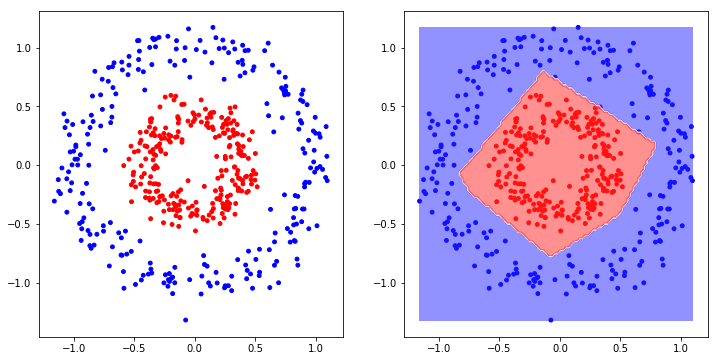

In [41]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=10000, verbose=1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

In [42]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/20000 data_loss:0.01063497 reg_loss:0.00000000 cost:0.01063497
epoch: 2000/20000 data_loss:0.00151303 reg_loss:0.00000000 cost:0.00151303
epoch: 4000/20000 data_loss:0.00124989 reg_loss:0.00000000 cost:0.00124989
epoch: 6000/20000 data_loss:0.00105507 reg_loss:0.00000000 cost:0.00105507
epoch: 8000/20000 data_loss:0.00092749 reg_loss:0.00000000 cost:0.00092749
epoch: 10000/20000 data_loss:0.00085032 reg_loss:0.00000000 cost:0.00085032
epoch: 12000/20000 data_loss:0.00080996 reg_loss:0.00000000 cost:0.00080996
epoch: 14000/20000 data_loss:0.00079651 reg_loss:0.00000000 cost:0.00079651
epoch: 16000/20000 data_loss:0.00081701 reg_loss:0.00000000 cost:0.00081701
epoch: 18000/20000 data_loss:0.00085973 reg_loss:0.00000000 cost:0.00085973
epoch: 20000/20000 data_loss:0.00088183 reg_loss:0.00000000 cost:0.00088183
Acurácia: 96.50%


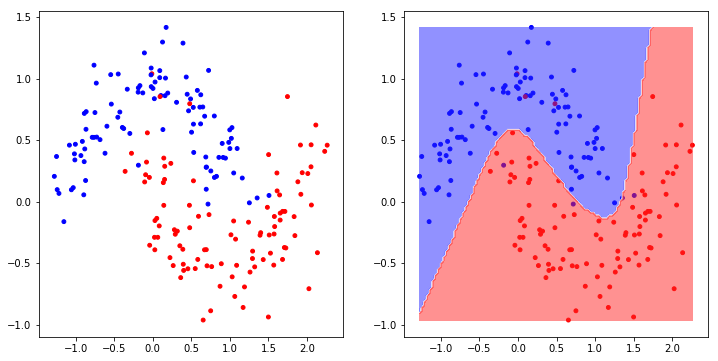

In [46]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=tanh))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=20000, verbose=2000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

In [47]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/20000 data_loss:0.00668812 reg_loss:0.00000000 cost:0.00668812
epoch: 2000/20000 data_loss:0.00238679 reg_loss:0.00000000 cost:0.00238679
epoch: 4000/20000 data_loss:0.00182726 reg_loss:0.00000000 cost:0.00182726
epoch: 6000/20000 data_loss:0.00136932 reg_loss:0.00000000 cost:0.00136932
epoch: 8000/20000 data_loss:0.00094153 reg_loss:0.00000000 cost:0.00094153
epoch: 10000/20000 data_loss:0.00075077 reg_loss:0.00000000 cost:0.00075077
epoch: 12000/20000 data_loss:0.00064157 reg_loss:0.00000000 cost:0.00064157
epoch: 14000/20000 data_loss:0.00056450 reg_loss:0.00000000 cost:0.00056450
epoch: 16000/20000 data_loss:0.00049382 reg_loss:0.00000000 cost:0.00049382
epoch: 18000/20000 data_loss:0.00041662 reg_loss:0.00000000 cost:0.00041662
epoch: 20000/20000 data_loss:0.00033970 reg_loss:0.00000000 cost:0.00033970
Acurácia: 99.00%


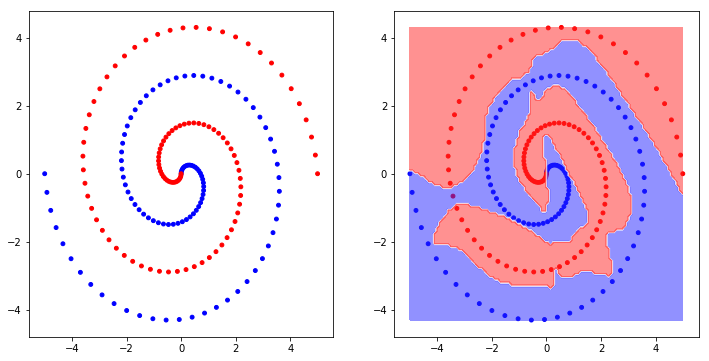

In [48]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=20000, verbose=2000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

In [49]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(300, 2) (300, 1)


In [50]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]


epoch:    0/10000 data_loss:0.01446398 reg_loss:0.44334769 cost:0.45781168
epoch: 1000/10000 data_loss:0.00059985 reg_loss:0.18369347 cost:0.18429332
epoch: 2000/10000 data_loss:0.00042326 reg_loss:0.17523225 cost:0.17565551
epoch: 3000/10000 data_loss:0.00036324 reg_loss:0.17328157 cost:0.17364482
epoch: 4000/10000 data_loss:0.00033183 reg_loss:0.17280331 cost:0.17313513
epoch: 5000/10000 data_loss:0.00031188 reg_loss:0.17276168 cost:0.17307356
epoch: 6000/10000 data_loss:0.00029867 reg_loss:0.17270317 cost:0.17300184
epoch: 7000/10000 data_loss:0.00028976 reg_loss:0.17246934 cost:0.17275910
epoch: 8000/10000 data_loss:0.00028207 reg_loss:0.17260966 cost:0.17289173
epoch: 9000/10000 data_loss:0.00027737 reg_loss:0.17228944 cost:0.17256681
epoch: 10000/10000 data_loss:0.00027216 reg_loss:0.17247844 cost:0.17275060
[[ 0.90307088  0.17997111]
 [ 0.10446491 -0.84133696]]
[[-0.14016292  0.77368013]
 [-0.61087457 -0.5057874 ]
 [ 0.75097265 -0.26778016]]
Acurácia: 100.00%


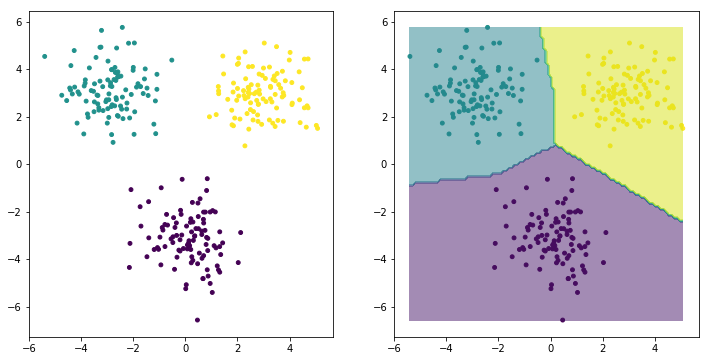

In [66]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, reg_func=l2_regularization, reg_strength=0.1)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

for layer in nn.layers:
    print(layer.weights)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

In [67]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(400, 2) (400, 1)


In [68]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


epoch:    0/10000 data_loss:0.00727110 reg_loss:0.00000000 cost:0.00727110
epoch: 1000/10000 data_loss:0.00041770 reg_loss:0.00000000 cost:0.00041770
epoch: 2000/10000 data_loss:0.00032479 reg_loss:0.00000000 cost:0.00032479
epoch: 3000/10000 data_loss:0.00029065 reg_loss:0.00000000 cost:0.00029065
epoch: 4000/10000 data_loss:0.00027140 reg_loss:0.00000000 cost:0.00027140
epoch: 5000/10000 data_loss:0.00025863 reg_loss:0.00000000 cost:0.00025863
epoch: 6000/10000 data_loss:0.00024947 reg_loss:0.00000000 cost:0.00024947
epoch: 7000/10000 data_loss:0.00024249 reg_loss:0.00000000 cost:0.00024249
epoch: 8000/10000 data_loss:0.00023697 reg_loss:0.00000000 cost:0.00023697
epoch: 9000/10000 data_loss:0.00023249 reg_loss:0.00000000 cost:0.00023249
epoch: 10000/10000 data_loss:0.00022874 reg_loss:0.00000000 cost:0.00022874
Acurácia: 96.75%


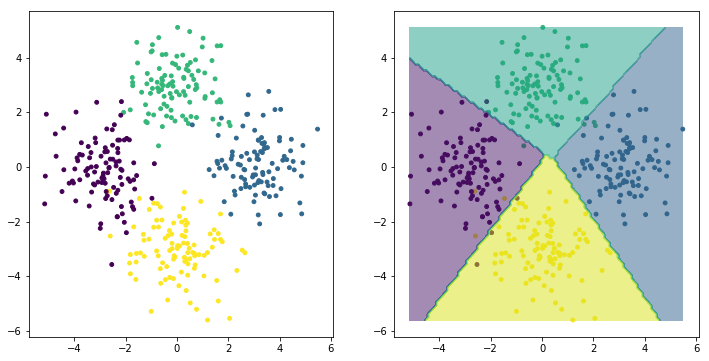

In [69]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

In [70]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


In [71]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


epoch:    0/10000 data_loss:0.05090230 reg_loss:0.00000000 cost:0.05090230
epoch: 1000/10000 data_loss:0.00060717 reg_loss:0.00000000 cost:0.00060717
epoch: 2000/10000 data_loss:0.00030377 reg_loss:0.00000000 cost:0.00030377
epoch: 3000/10000 data_loss:0.00018976 reg_loss:0.00000000 cost:0.00018976
epoch: 4000/10000 data_loss:0.00014089 reg_loss:0.00000000 cost:0.00014089
epoch: 5000/10000 data_loss:0.00011646 reg_loss:0.00000000 cost:0.00011646
epoch: 6000/10000 data_loss:0.00010169 reg_loss:0.00000000 cost:0.00010169
epoch: 7000/10000 data_loss:0.00009122 reg_loss:0.00000000 cost:0.00009122
epoch: 8000/10000 data_loss:0.00008470 reg_loss:0.00000000 cost:0.00008470
epoch: 9000/10000 data_loss:0.00007882 reg_loss:0.00000000 cost:0.00007882
epoch: 10000/10000 data_loss:0.00007442 reg_loss:0.00000000 cost:0.00007442
Acurácia: 99.00%


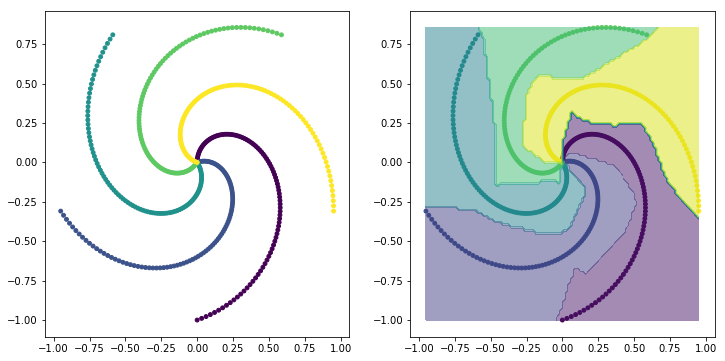

In [72]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [73]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


In [74]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


epoch:    0/10000 data_loss:0.03345983 reg_loss:0.00000000 cost:0.03345983
epoch: 1000/10000 data_loss:0.00353358 reg_loss:0.00000000 cost:0.00353358
epoch: 2000/10000 data_loss:0.00282361 reg_loss:0.00000000 cost:0.00282361
epoch: 3000/10000 data_loss:0.00256992 reg_loss:0.00000000 cost:0.00256992
epoch: 4000/10000 data_loss:0.00241599 reg_loss:0.00000000 cost:0.00241599
epoch: 5000/10000 data_loss:0.00229419 reg_loss:0.00000000 cost:0.00229419
epoch: 6000/10000 data_loss:0.00218661 reg_loss:0.00000000 cost:0.00218661
epoch: 7000/10000 data_loss:0.00204250 reg_loss:0.00000000 cost:0.00204250
epoch: 8000/10000 data_loss:0.00188501 reg_loss:0.00000000 cost:0.00188501
epoch: 9000/10000 data_loss:0.00172613 reg_loss:0.00000000 cost:0.00172613
epoch: 10000/10000 data_loss:0.00160227 reg_loss:0.00000000 cost:0.00160227
Acurácia: 95.00%


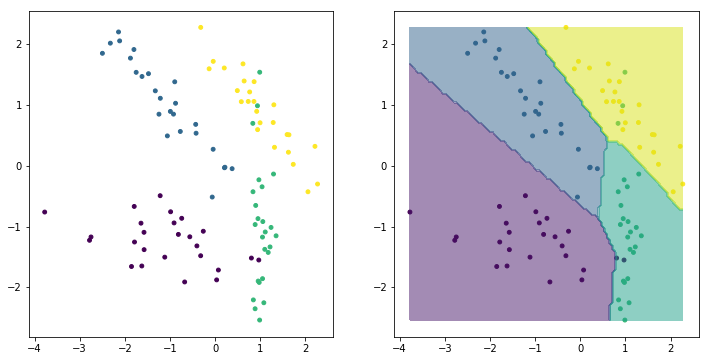

In [75]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [76]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [77]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


epoch:    0/10000 data_loss:0.01193747 reg_loss:0.00000000 cost:0.01193747
epoch: 1000/10000 data_loss:0.00382248 reg_loss:0.00000000 cost:0.00382248
epoch: 2000/10000 data_loss:0.00297651 reg_loss:0.00000000 cost:0.00297651
epoch: 3000/10000 data_loss:0.00236894 reg_loss:0.00000000 cost:0.00236894
epoch: 4000/10000 data_loss:0.00189571 reg_loss:0.00000000 cost:0.00189571
epoch: 5000/10000 data_loss:0.00155812 reg_loss:0.00000000 cost:0.00155812
epoch: 6000/10000 data_loss:0.00131792 reg_loss:0.00000000 cost:0.00131792
epoch: 7000/10000 data_loss:0.00115116 reg_loss:0.00000000 cost:0.00115116
epoch: 8000/10000 data_loss:0.00103668 reg_loss:0.00000000 cost:0.00103668
epoch: 9000/10000 data_loss:0.00095684 reg_loss:0.00000000 cost:0.00095684
epoch: 10000/10000 data_loss:0.00089460 reg_loss:0.00000000 cost:0.00089460
Acurácia: 96.00%


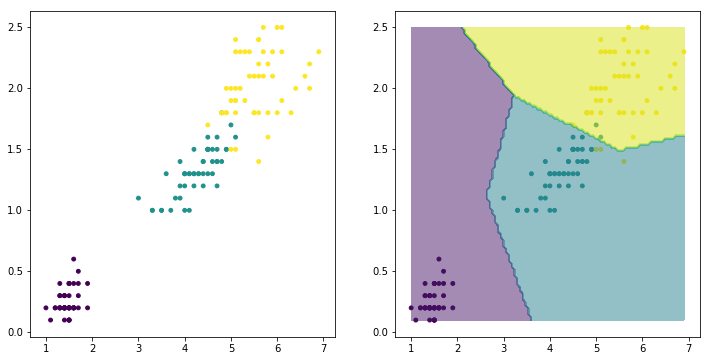

In [79]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__TODO__:
- evitar overflow das funções de ativação
- mini-batch SGD
- dropout
- early_stopping

```py
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)
```

__NOTAS__:

__Inicialização dos pesos__:
- mostrar a documentação das funções np.random.rand e np.random.randn para mostrar como gerar distribuições na faixa [-limit, limit] e com média zero e certo desvio-padrão.
- mostrar que os métodos de inicialização de pesos ones e random_uniform podem não ser adequados para alguns problemas, como o do espiral binário.

__Regularização__:
- mostrar que a regularização dos pesos nem sempre ajuda. Em alguns casos, como o espiral multiclasse, temos que definir a reg_strength muito pequena. Isto é, estamos dizendo que o valores dos pesos não podem influenciar no custo. Em outras palavras, isso é a mesma coisa que "desligar" a regularização.